In [180]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [181]:
import nltk
import re
from wordcloud import WordCloud

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [182]:
column_names = [
    'id', 'label', 'statement', 'subject', 'speaker', 'speaker_job_title',
    'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts',
    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
    'context'
]

In [183]:
df = pd.read_csv('train.tsv', sep='\t', header=None)

df.columns = column_names

df['id'] = df['id'].str.replace('.json', '', regex=False)

In [184]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

df['statement'] = df['statement'].apply(clean_text)

In [185]:
df.head()

,id,label,statement,subject,speaker,speaker_job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


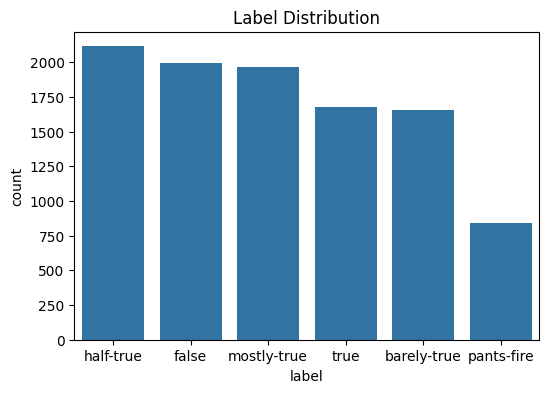

In [186]:
# Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title('Label Distribution')
plt.show()

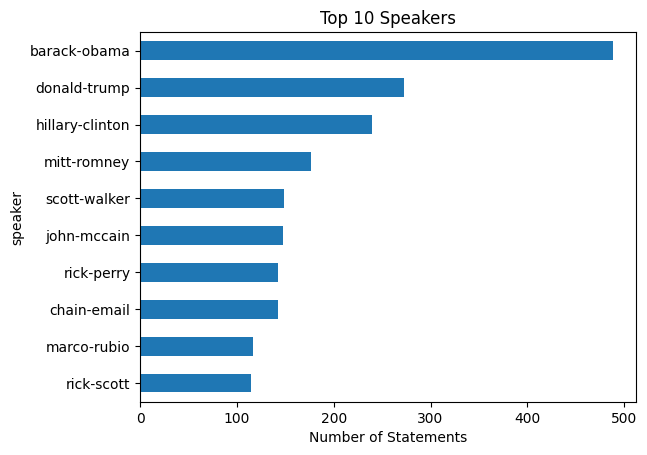

In [187]:
top_speakers = df['speaker'].value_counts().head(10)
top_speakers.plot(kind='barh')
plt.title("Top 10 Speakers")
plt.xlabel("Number of Statements")
plt.gca().invert_yaxis()
plt.show()

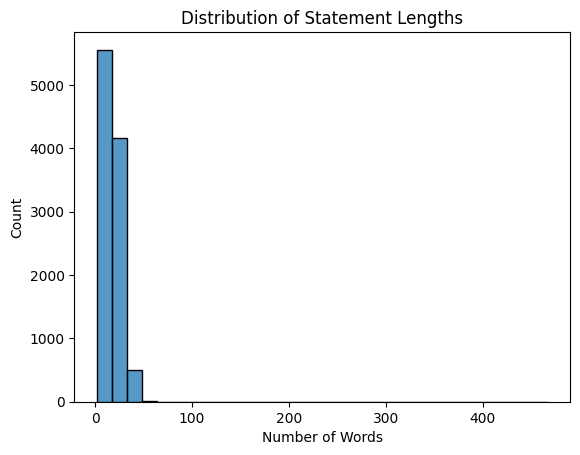

In [188]:
# Statement length distribution
df['statement_len'] = df['statement'].astype(str).apply(lambda x: len(x.split()))
sns.histplot(df['statement_len'], bins=30)
plt.title('Distribution of Statement Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()



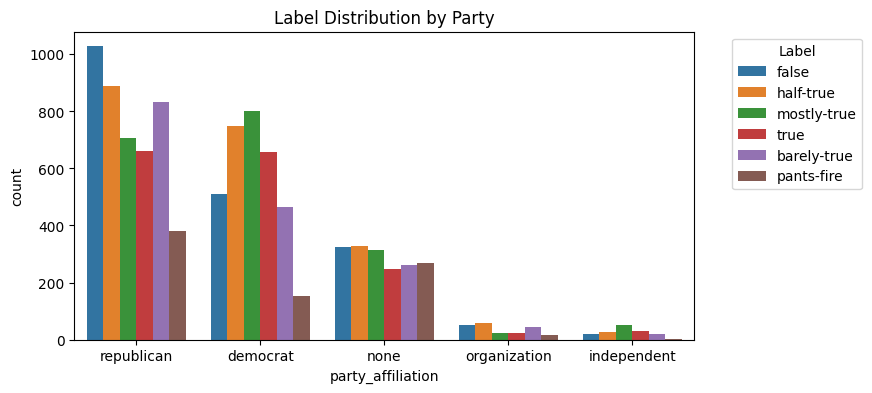

In [189]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='party_affiliation', hue='label', order=df['party_affiliation'].value_counts().head(5).index)
plt.title("Label Distribution by Party")
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [190]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [191]:
from nltk import ngrams
from collections import Counter

def get_top_ngrams(text_series, n=2, top_k=20):
    all_ngrams = []
    for sentence in text_series.dropna():
        sentence = re.sub(r'[^a-z\s]', '', sentence.lower())
        tokens = [word for word in sentence.split() if word not in stop_words]
        all_ngrams += list(ngrams(tokens, n))
    return Counter(all_ngrams).most_common(top_k)

Top Bigrams: [(('health', 'care'), 401), (('united', 'states'), 298), (('barack', 'obama'), 281), (('hillary', 'clinton'), 169), (('president', 'barack'), 156), (('social', 'security'), 131), (('president', 'obama'), 121), (('donald', 'trump'), 116), (('health', 'insurance'), 109), (('mitt', 'romney'), 104), (('scott', 'walker'), 95), (('says', 'president'), 91), (('rhode', 'island'), 87), (('last', 'year'), 85), (('says', 'hillary'), 85), (('federal', 'government'), 78), (('says', 'us'), 74), (('new', 'jersey'), 72), (('us', 'senate'), 71), (('says', 'donald'), 69)]


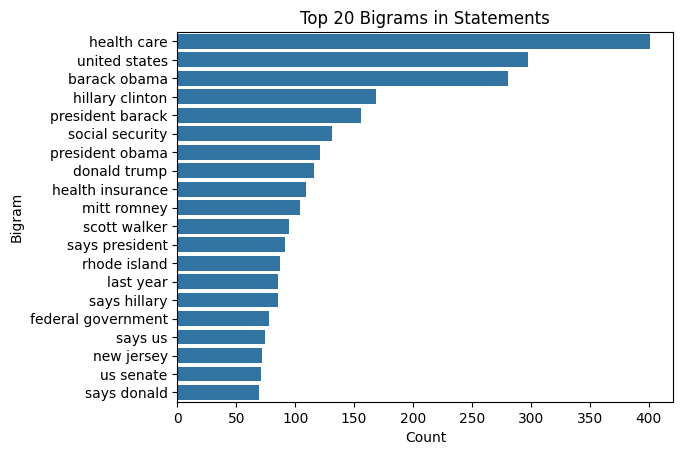

In [192]:
top_bigrams = get_top_ngrams(df['statement'], n=2)
print("Top Bigrams:", top_bigrams)

bigrams_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Count'])
bigrams_df['Bigram'] = bigrams_df['Bigram'].apply(lambda x: ' '.join(x))
sns.barplot(data=bigrams_df, x='Count', y='Bigram')
plt.title("Top 20 Bigrams in Statements")
plt.show()

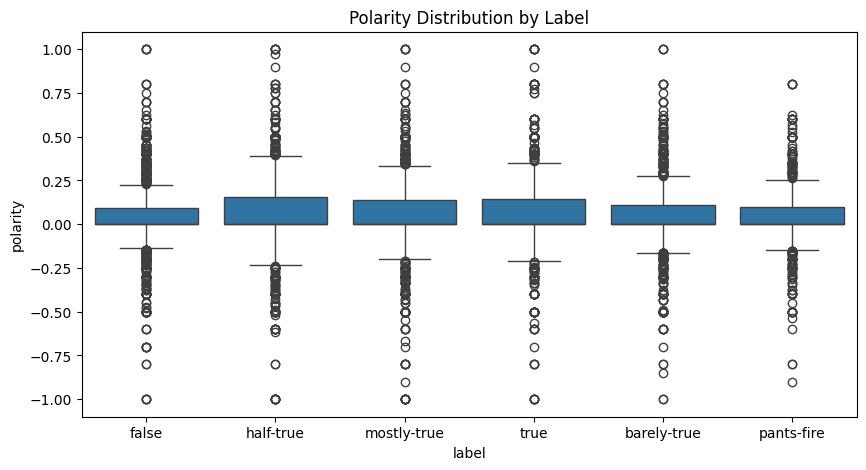

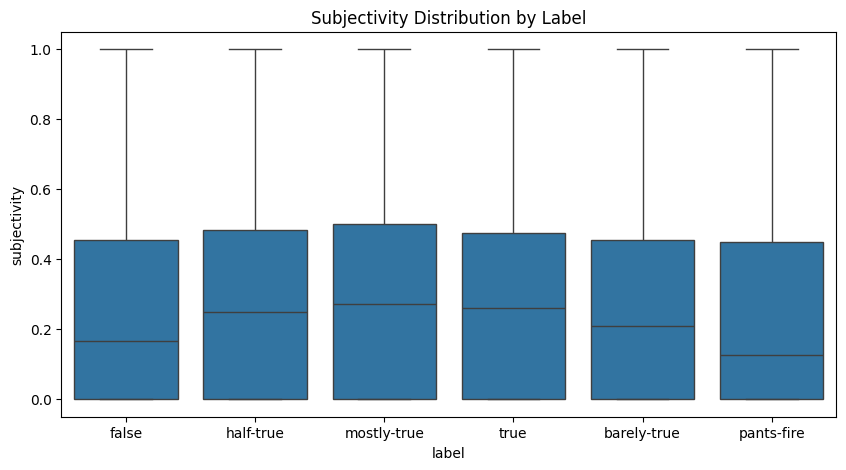

In [193]:
# Sentiment Analysis
from textblob import TextBlob

df['polarity'] = df['statement'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['statement'].astype(str).apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Sentiment vs Label
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='label', y='polarity')
plt.title("Polarity Distribution by Label")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='label', y='subjectivity')
plt.title("Subjectivity Distribution by Label")
plt.show()

Processing NER for 10240 statements...


Processing NER batches: 100%|██████████| 205/205 [00:38<00:00,  5.30it/s]


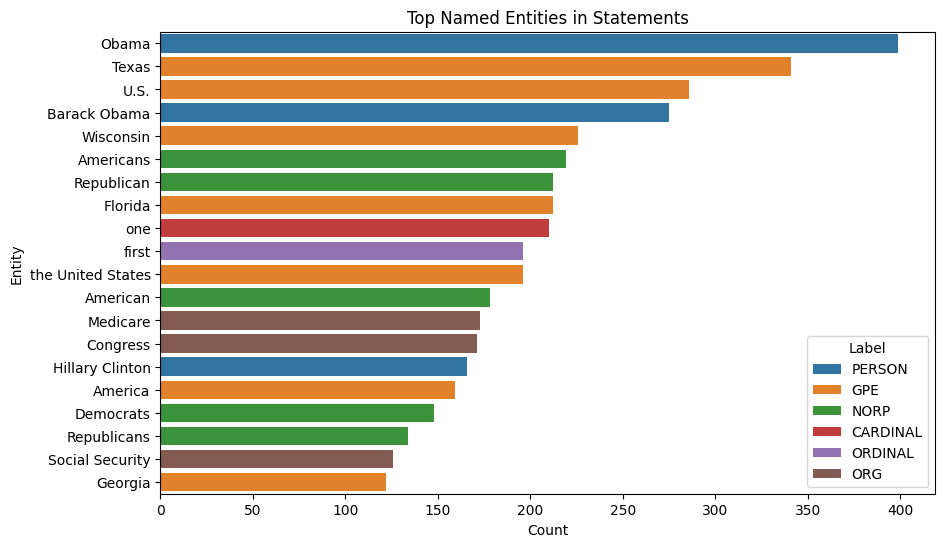

Processed 22761 total entities
Found 7444 unique entities


In [194]:
import spacy
from collections import defaultdict
import pandas as pd
from tqdm import tqdm

def process_ner_batch(texts, nlp_model, batch_size=100):

    entity_counter = defaultdict(int)

    if isinstance(texts, pd.Series):
        texts = texts.dropna().tolist()

    for i in tqdm(range(0, len(texts), batch_size), desc="Processing NER batches"):
        batch = texts[i:i + batch_size]

        docs = nlp_model.pipe(batch, disable=["lemmatizer", "tagger"])
        for doc in docs:
            for ent in doc.ents:
                if len(ent.text.strip()) > 1:
                    entity_counter[(ent.text.strip(), ent.label_)] += 1

        if i % (batch_size * 10) == 0:
            import gc
            gc.collect()

    return entity_counter

nlp = spacy.load("en_core_web_sm", disable=["lemmatizer", "tagger"])
nlp.max_length = 2000000


print(f"Processing NER for {len(df['statement'].dropna())} statements...")

entity_counter = process_ner_batch(df['statement'], nlp, batch_size=50)


top_entities = sorted(entity_counter.items(), key=lambda x: x[1], reverse=True)[:20]

entity_texts = [x[0][0] for x in top_entities]
entity_labels = [x[0][1] for x in top_entities]
entity_counts = [x[1] for x in top_entities]

entity_df = pd.DataFrame({
    "Entity": entity_texts,
    "Label": entity_labels,
    "Count": entity_counts
})

plt.figure(figsize=(10, 6))
sns.barplot(data=entity_df, y="Entity", x="Count", hue="Label", dodge=False)
plt.title("Top Named Entities in Statements")
plt.show()

print(f"Processed {sum(entity_counter.values())} total entities")
print(f"Found {len(entity_counter)} unique entities")

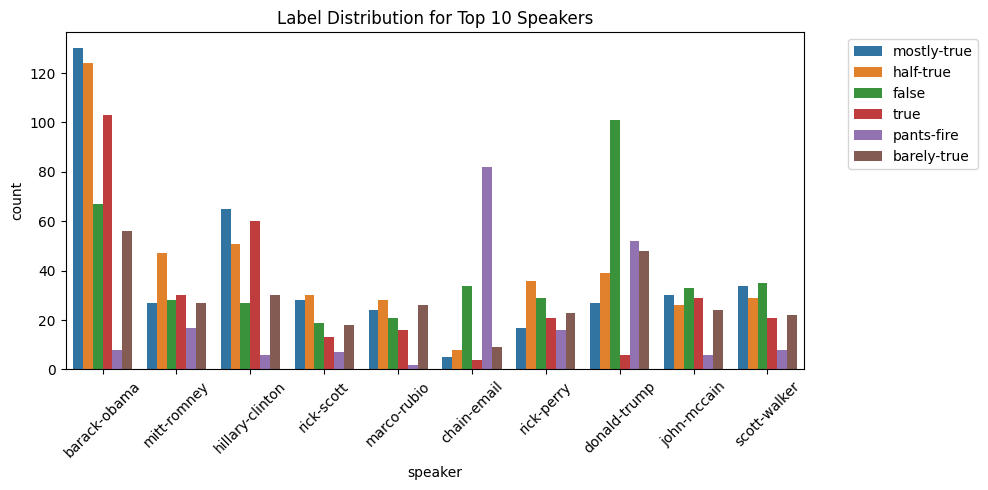

In [195]:
top_speakers = df['speaker'].value_counts().head(10).index.tolist()
speaker_df = df[df['speaker'].isin(top_speakers)]

plt.figure(figsize=(10, 5))
sns.countplot(data=speaker_df, x='speaker', hue='label')
plt.title("Label Distribution for Top 10 Speakers")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


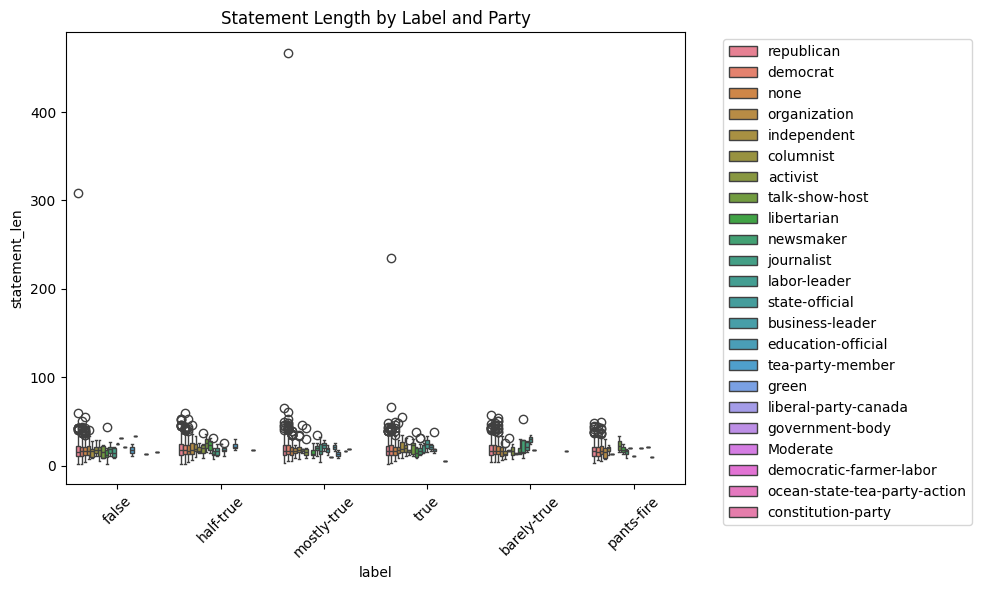

In [196]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='label', y='statement_len', hue='party_affiliation')
plt.title("Statement Length by Label and Party")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [197]:
print("Unique labels:", df['label'].unique())

Unique labels: ['false' 'half-true' 'mostly-true' 'true' 'barely-true' 'pants-fire']


In [198]:
label_map = {
    'pants-fire': 0,
    'false': 1,
    'barely-true': 2,
    'half-true': 3,
    'mostly-true': 4,
    'true': 5
}


In [199]:
df['label_num'] = df['label'].map(label_map)

In [200]:
val_df = pd.read_csv("valid.tsv", sep='\t', header=None)
test_df = pd.read_csv("test.tsv", sep='\t', header=None)

val_df.columns = column_names
test_df.columns = column_names

In [201]:
val_df['id'] = val_df['id'].str.replace('.json', '', regex=False)
test_df['id'] = test_df['id'].str.replace('.json', '', regex=False)


val_df['label_num'] = val_df['label'].map(label_map)
test_df['label_num'] = test_df['label'].map(label_map)

In [202]:
print("Val label_num created:", val_df['label_num'].notna().sum(), "records")
print("Test label_num created:", test_df['label_num'].notna().sum(), "records")

Val label_num created: 1284 records
Test label_num created: 1267 records


In [203]:
val_df['statement'] = val_df['statement'].apply(clean_text)
test_df['statement'] = test_df['statement'].apply(clean_text)

In [204]:
val_df['statement_len'] = val_df['statement'].astype(str).apply(lambda x: len(x.split()))
test_df['statement_len'] = test_df['statement'].astype(str).apply(lambda x: len(x.split()))

In [205]:
# Polarity and Subjectivity

from textblob import TextBlob

val_df['polarity'] = val_df['statement'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
val_df['subjectivity'] = val_df['statement'].astype(str).apply(lambda x: TextBlob(x).sentiment.subjectivity)

test_df['polarity'] = test_df['statement'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
test_df['subjectivity'] = test_df['statement'].astype(str).apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [206]:
print("Train label_num info:")
print(df['label_num'].value_counts().sort_index())
print("\nVal label_num info:")
print(val_df['label_num'].value_counts().sort_index())
print("\nTest label_num info:")
print(test_df['label_num'].value_counts().sort_index())


Train label_num info:
label_num
0     839
1    1995
2    1654
3    2114
4    1962
5    1676
Name: count, dtype: int64

Val label_num info:
label_num
0    116
1    263
2    237
3    248
4    251
5    169
Name: count, dtype: int64

Test label_num info:
label_num
0     92
1    249
2    212
3    265
4    241
5    208
Name: count, dtype: int64


In [207]:
val_df = val_df[df.columns]
test_df = test_df[df.columns]

In [208]:
df.to_csv("train_liar.csv", index=False)
val_df.to_csv("val_liar.csv", index=False)
test_df.to_csv("test_liar.csv", index=False)